In [1]:
!pip install scikit-learn==1.3.0

In [2]:
import pandas as pd
import missingno as msno

url = "https://raw.githubusercontent.com/WiraDKP/supervised_learning/refs/heads/master/07%20-%20Boosting/data/life_expectancy.csv"
data = pd.read_csv(url)

data.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## **Missing Values**

<Axes: >

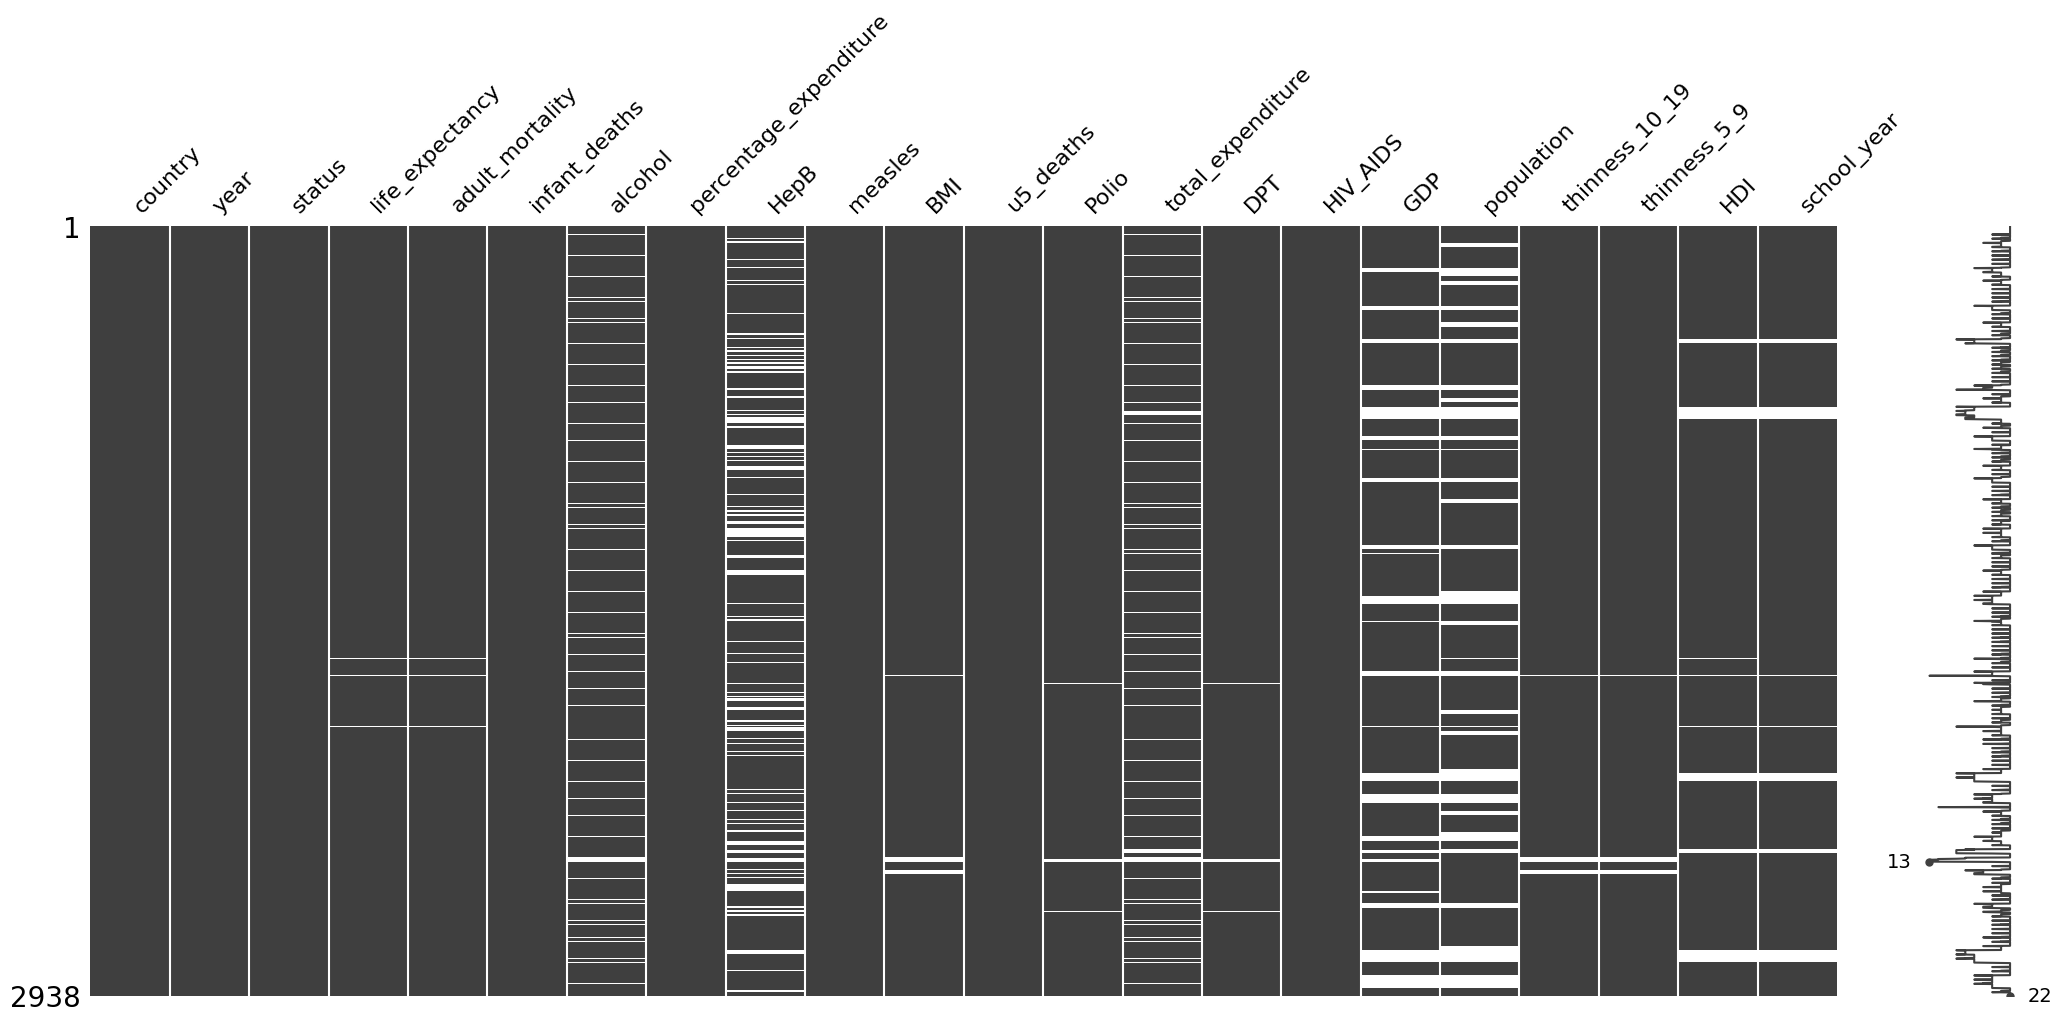

In [3]:
msno.matrix(data)

In [4]:
data = data[~data.life_expectancy.isna()]

## Corellation Matrix

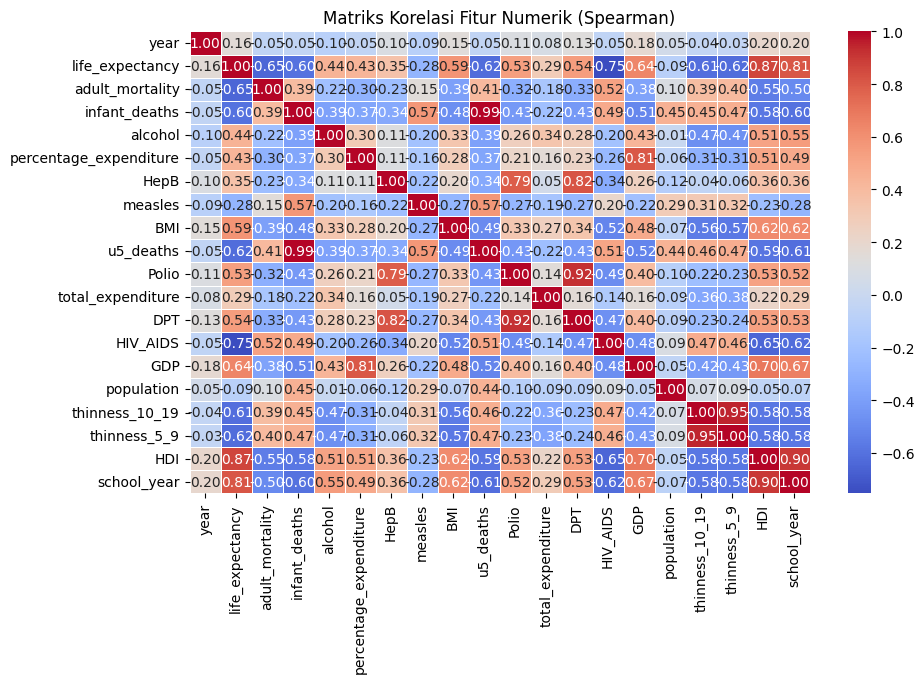

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih metode: "pearson", "spearman", atau "kendall"
correlation_method = "spearman"

plt.figure(figsize=(10, 6))
sns.heatmap(data.select_dtypes(include=["number"]).corr(method=correlation_method),
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Matriks Korelasi Fitur Numerik ({correlation_method.capitalize()})")
plt.show()

## **Splitting**

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="life_expectancy")
y = data["life_expectancy"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

In [ ]:
X_train.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

## **Training**

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

numerical_features = ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure',
                      'HepB', 'measles', 'BMI', 'u5_deaths', 'Polio', 'total_expenditure', 'DPT',
                      'HIV_AIDS', 'GDP', 'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

categorical_features = ['country', 'status']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42, verbosity=1))
])

parameter = {
    'algo__max_depth': [3, 6],
    'algo__learning_rate': [0.05, 0.1, 0.2],
    'algo__n_estimators': [50, 100, 200],
    'algo__subsample': [0.7, 0.9],
    'algo__gamma': [0, 0.1, 0.3],
    'algo__colsample_bytree': [0.7, 0.9],
    'algo__reg_alpha': [0.01, 0.1],
    'algo__reg_lambda': [0.1, 1.0]
}

In [8]:
model = RandomizedSearchCV(pipeline, param_distributions=parameter, n_iter=50, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('yeojohnson',
                                                                                                PowerTransformer()),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(include_bias=False,
                                                                                                                   interaction_only=True))]),
                                                                               ['year',
                                                                                'adult_mortality',
                                                                                'infant_deaths',
                                                                                'alcohol...
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__colsample_bytree': [0.7, 0.9],
                                        'algo__gamma': [0, 0.1, 0.3],
                                        'algo__learning_rate': [0.05, 0.1, 0.2],
                                        'algo__max_depth': [3, 6],
                                        'algo__n_estimators': [50, 100, 200],
                                        'algo__reg_alpha': [0.01, 0.1],
                                        'algo__reg_lambda': [0.1, 1.0],
                                        'algo__subsample': [0.7, 0.9]},
                   verbose=1)

In [9]:
print(f"Best parameters: {model.best_params_}")
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Best parameters: {'algo__subsample': 0.9, 'algo__reg_lambda': 0.1, 'algo__reg_alpha': 0.01, 'algo__n_estimators': 100, 'algo__max_depth': 6, 'algo__learning_rate': 0.1, 'algo__gamma': 0, 'algo__colsample_bytree': 0.9}
0.9959931625894026 0.9562940772291638 0.9640222467718108


## Evaluasi Model

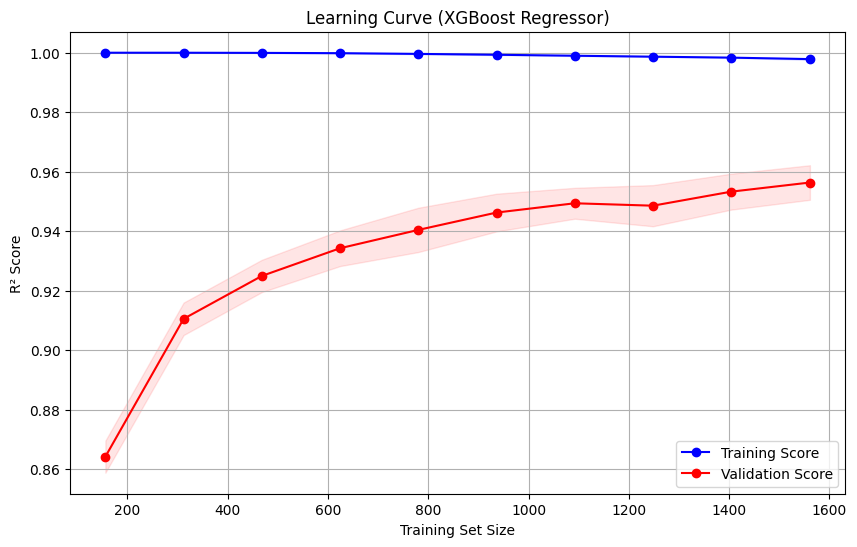

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

best_model = model.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=3, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Validation Score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="red")

plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve (XGBoost Regressor)")
plt.legend()
plt.grid()
plt.show()

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Train R² Score: {r2_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train MAPE: {mape_train:.2f}%\n")

print("**Evaluasi pada Data Test**")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%")

Jumlah data train: 2342
Jumlah data test: 586

**Evaluasi pada Data Train**
Train R² Score: 0.9960
Train MAE: 0.4400
Train MSE: 0.3674
Train RMSE: 0.6061
Train MAPE: 0.64%

**Evaluasi pada Data Test**
Test R² Score: 0.9640
Test MAE: 1.1351
Test MSE: 3.1121
Test RMSE: 1.7641
Test MAPE: 1.70%


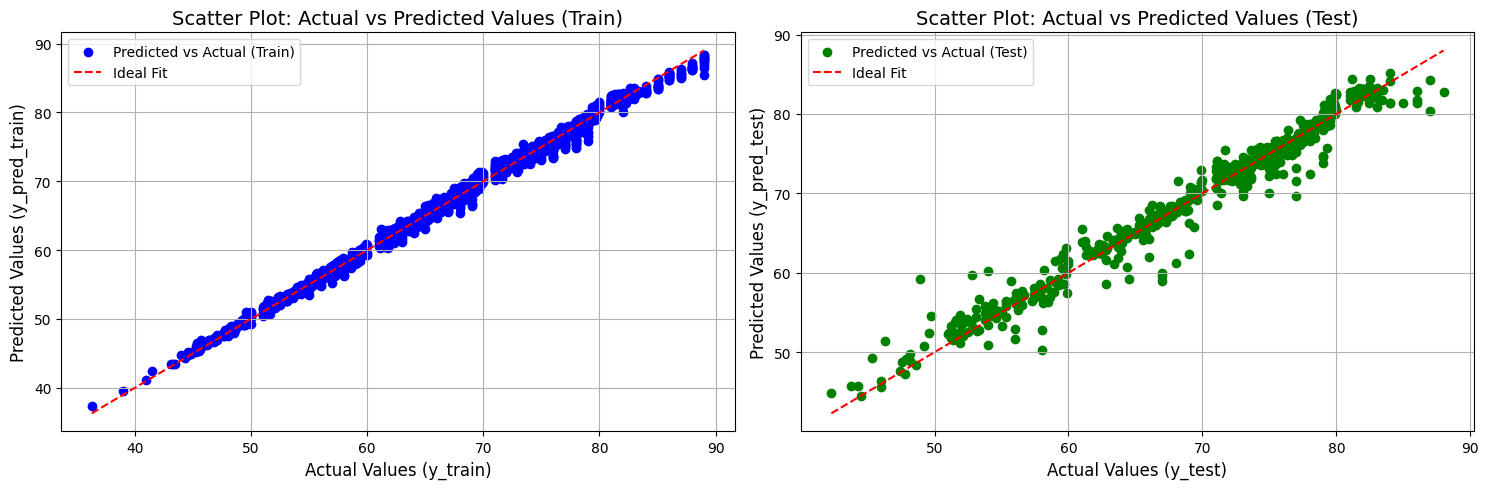

In [14]:
import matplotlib.pyplot as plt

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_train, y_pred_train, color='blue', label='Predicted vs Actual (Train)')
axes[0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Ideal Fit')
axes[0].set_title('Scatter Plot: Actual vs Predicted Values (Train)', fontsize=14)
axes[0].set_xlabel('Actual Values (y_train)', fontsize=12)
axes[0].set_ylabel('Predicted Values (y_pred_train)', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(y_test, y_pred_test, color='green', label='Predicted vs Actual (Test)')
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
axes[1].set_title('Scatter Plot: Actual vs Predicted Values (Test)', fontsize=14)
axes[1].set_xlabel('Actual Values (y_test)', fontsize=12)
axes[1].set_ylabel('Predicted Values (y_pred_test)', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

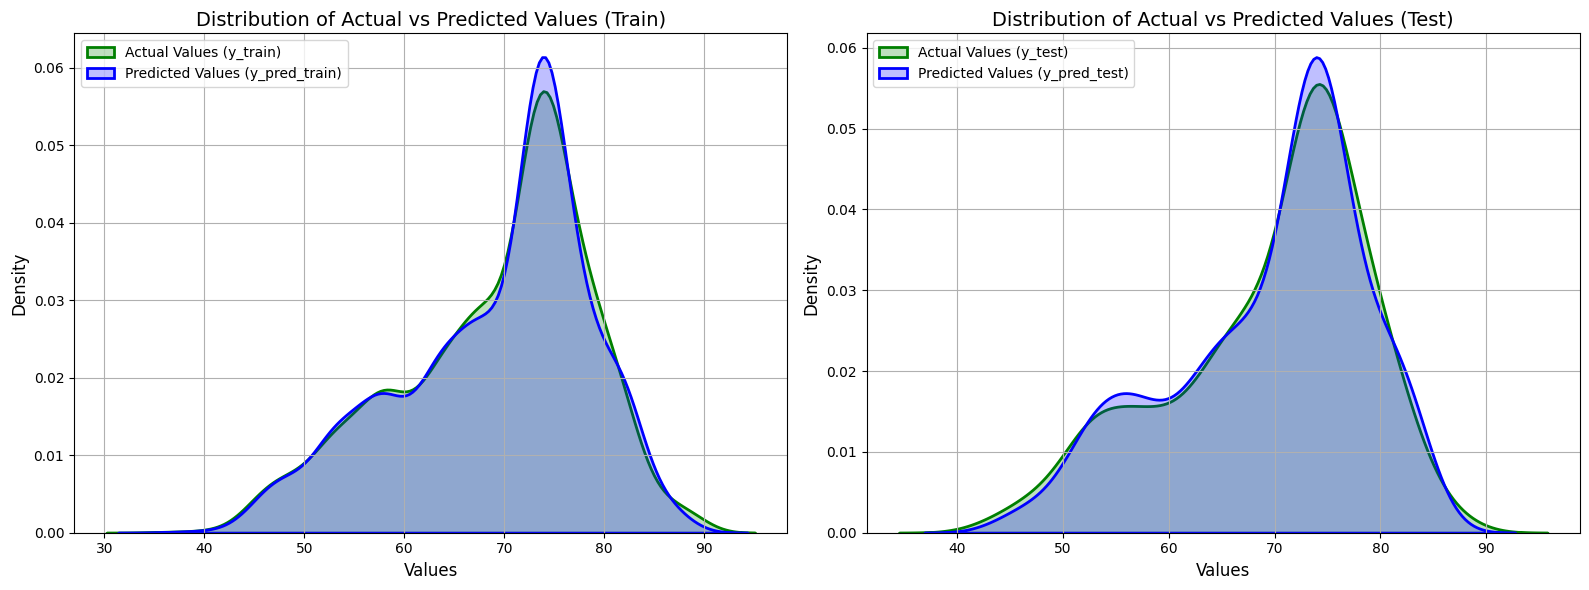

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(y_train, color='green', label='Actual Values (y_train)', fill=True, linewidth=2, ax=axes[0])
sns.kdeplot(y_pred_train, color='blue', label='Predicted Values (y_pred_train)', fill=True, linewidth=2, ax=axes[0])

axes[0].set_title('Distribution of Actual vs Predicted Values (Train)', fontsize=14)
axes[0].set_xlabel('Values', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend()
axes[0].grid(True)

sns.kdeplot(y_test, color='green', label='Actual Values (y_test)', fill=True, linewidth=2, ax=axes[1])
sns.kdeplot(y_pred_test, color='blue', label='Predicted Values (y_pred_test)', fill=True, linewidth=2, ax=axes[1])

axes[1].set_title('Distribution of Actual vs Predicted Values (Test)', fontsize=14)
axes[1].set_xlabel('Values', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

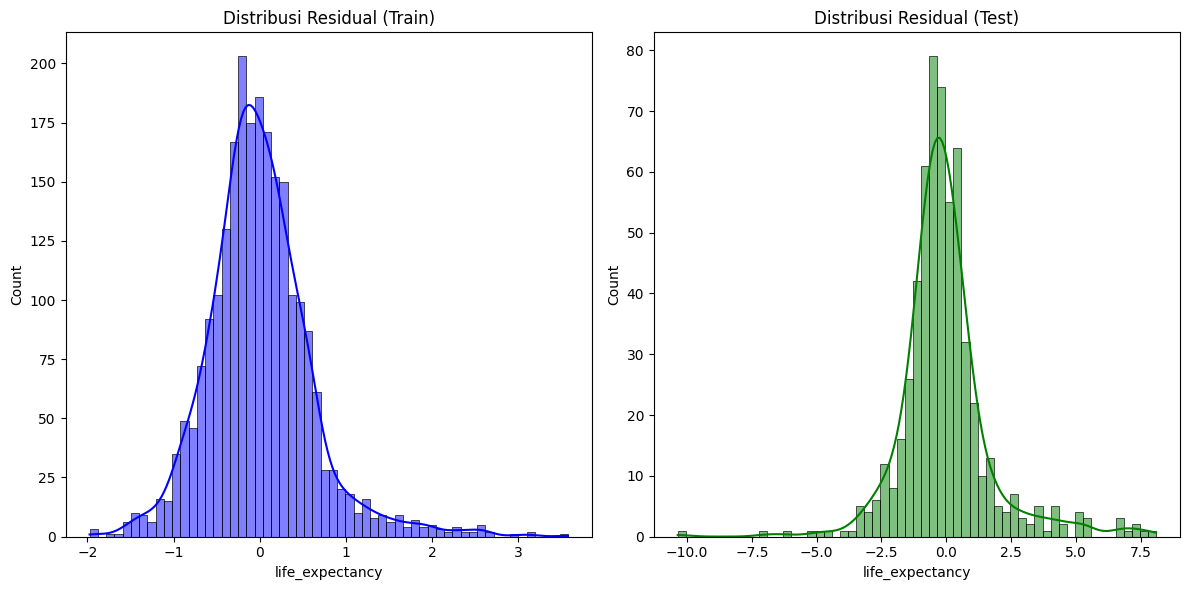

In [16]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals_train, kde=True, color='blue')
plt.title("Distribusi Residual (Train)")

plt.subplot(1, 2, 2)
sns.histplot(residuals_test, kde=True, color='green')
plt.title("Distribusi Residual (Test)")

plt.tight_layout()
plt.show()

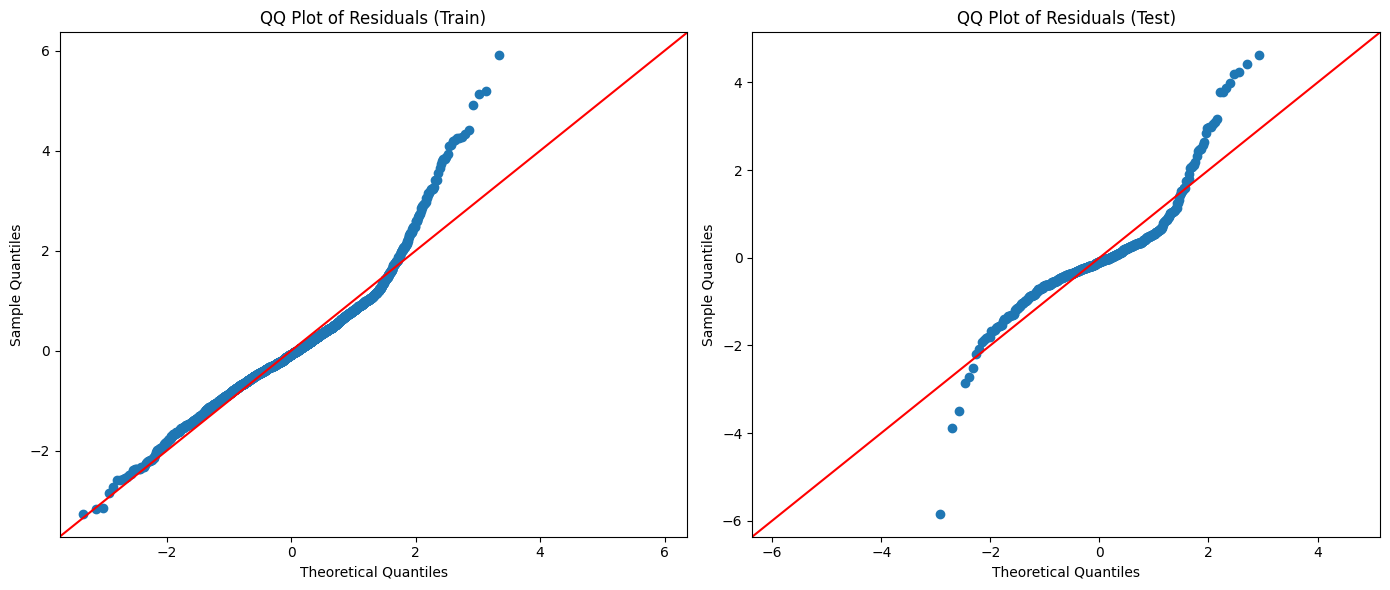

In [17]:
import statsmodels.api as sm

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sm.qqplot(residuals_train, line='45', fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals (Train)")

plt.subplot(1, 2, 2)
sm.qqplot(residuals_test, line='45', fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals (Test)")

plt.tight_layout()
plt.show()

## **Feature Importance**

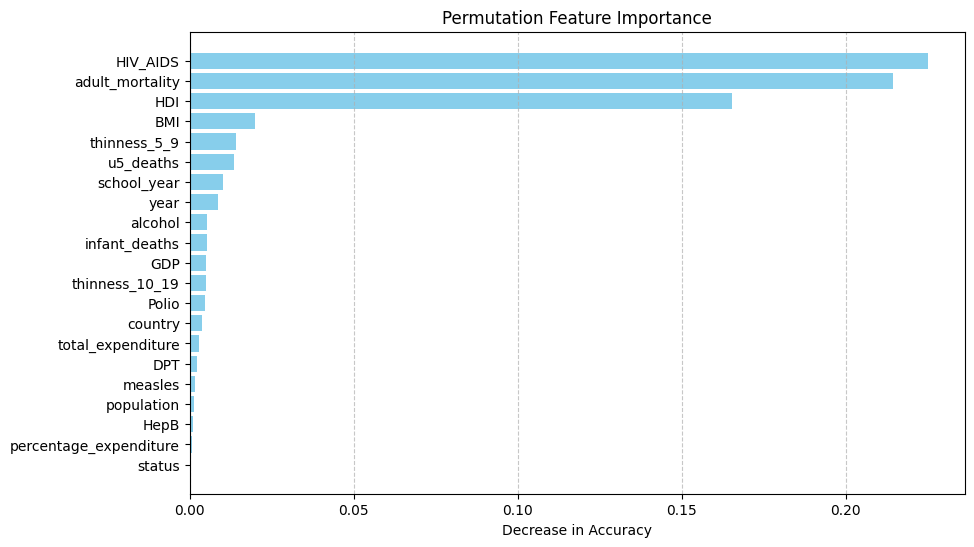

In [18]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.title('Permutation Feature Importance')
plt.xlabel('Decrease in Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Prediksi

In [23]:
X_train.iloc[1]

,1680
country,Mauritius
year,2002
status,Developing
adult_mortality,179.0
infant_deaths,0
alcohol,4.14
percentage_expenditure,369.63171
HepB,88.0
measles,0
BMI,26.4


In [24]:
X_train.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

In [21]:
data['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', "Côte d'Ivoire", 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Canada', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Grenad

In [25]:
import pandas as pd

pd.set_option('display.max_columns', 200)

new_data = pd.DataFrame({
    'country': ['Indonesia', 'Malaysia'],
    'year': [2025, 2026],
    'status': ['Developing', 'Developing'],
    'adult_mortality': [180, 160],
    'infant_deaths': [15, 10],
    'alcohol': [0.5, 1.2],
    'percentage_expenditure': [200, 150],
    'HepB': [85, 90],
    'measles': [500, 300],
    'BMI': [23.5, 25.0],
    'u5_deaths': [20, 12],
    'Polio': [90, 92],
    'total_expenditure': [5.5, 6.2],
    'DPT': [88, 91],
    'HIV_AIDS': [0.2, 0.1],
    'GDP': [4000, 10000],
    'population': [270000000, 33000000],
    'thinness_10_19': [3.5, 2.8],
    'thinness_5_9': [4.2, 3.0],
    'HDI': [0.72, 0.80],
    'school_year': [12, 13]
})

new_data['Predict'] = model.predict(new_data)
new_data

,country,year,status,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,BMI,u5_deaths,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year,Predict
0,Indonesia,2025,Developing,180,15,0.5,200,85,500,23.5,20,90,5.5,88,0.2,4000,270000000,3.5,4.2,0.72,12,70.837914
1,Malaysia,2026,Developing,160,10,1.2,150,90,300,25.0,12,92,6.2,91,0.1,10000,33000000,2.8,3.0,0.80,13,73.908234


## Save Model

In [26]:
import pickle

best_pipeline = model.best_estimator_
with open("lifeexpetancy.pkl", "wb") as file:
    pickle.dump(best_pipeline, file)